# Технический анализ рынка Российских акций и прогноз цены с использованием нейросетей.

В данная дипломной работе мы проведем анализ четырех Российских компаний из разных секторов рынка, получим данные с сайта Yahoo-finans, рассмотрим технический анализ, рассчитаем прогноз рисков и с помощью нейросети попробую предсказать цену на акции.

# Подготовка

In [1]:
%%capture
# Модуль Python для получения биржевых данных от Yahoo!
!pip install yahoo-fin                    

In [2]:
# Библиотека готовых шаблонов для статистической визуализации
import seaborn as sns
%matplotlib inline
# Работа с массивами данных
import numpy as np 
# Работа с табличными данными
import pandas as pd
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input
from tensorflow.keras.layers import  LSTM
# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
# Масштабирование данных
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Загрузка датасетов из облака google
import gdown
# Регулярные выражения
import re
# Отрисовка графиков
import matplotlib.pyplot as plt
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error
from yahoo_fin.stock_info import *
sns.set_style('dark')
plt.style.use("bmh")
# Модуль для работы с датами и временем
from datetime import datetime                        

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Аналитика

Выбираем компании для технического анализа, из "Нефтегазового сектора" возьмем компанию Газпром ,из "Финансовый сектор" возьмем Сбербанк, "Сектор металургии и Добычи" это Северсталь и "Потребительский сектор" будет Магнит.

In [4]:
# Задаем переменные тикеров и названий компаний.
ticker_list = ['GAZP.ME', 'SBER.ME', 'CHMF.ME', 'MGNT.ME']
company_name = ["Газпром", "Сбербанк", "Северсталь", "Магнит"]

In [5]:
# Задаем временные интервалы.
time_end = datetime(2022,1,1)
time_start = datetime(2021,1,1)

In [6]:
# Получаем данные по Газпрому сразу в таблице DataFrame.
GAZP = get_data("GAZP.ME", time_start, time_end)
GAZP

,open,high,low,close,adjclose,volume,ticker
2021-01-04,212.710007,216.630005,212.710007,214.809998,205.652847,44412080,GAZP.ME
2021-01-05,213.199997,214.850006,210.220001,214.350006,205.212463,44811540,GAZP.ME
2021-01-06,215.320007,216.800003,213.070007,215.199997,206.026230,42719400,GAZP.ME
2021-01-08,215.199997,215.199997,215.199997,215.199997,206.026230,0,GAZP.ME
2021-01-11,225.169998,231.000000,221.809998,227.410004,217.715729,108373880,GAZP.ME
...,...,...,...,...,...,...,...
2021-12-24,339.200012,340.769989,334.549988,338.250000,338.250000,35784290,GAZP.ME
2021-12-27,340.179993,343.500000,340.100006,342.779999,342.779999,26628780,GAZP.ME
2021-12-28,346.299988,346.570007,344.480011,345.000000,345.000000,29673520,GAZP.ME
2021-12-29,342.200012,343.850006,337.130005,339.489990,339.489990,39270301,GAZP.ME


In [7]:
# Получаем данные по Сбербанку.
SBER = get_data("SBER.ME", time_start, time_end)
SBER

,open,high,low,close,adjclose,volume,ticker
2021-01-04,274.670013,276.600006,272.540009,274.679993,258.593201,41277720,SBER.ME
2021-01-05,274.670013,275.700012,270.279999,273.519989,257.501129,42179430,SBER.ME
2021-01-06,275.940002,275.940002,271.619995,273.929993,257.887115,36784175,SBER.ME
2021-01-08,273.929993,273.929993,273.929993,273.929993,257.887115,0,SBER.ME
2021-01-11,282.859985,292.950012,279.480011,288.549988,271.650879,108435431,SBER.ME
...,...,...,...,...,...,...,...
2021-12-24,293.549988,294.179993,289.000000,293.619995,293.619995,35224451,SBER.ME
2021-12-27,294.660004,296.000000,293.369995,295.000000,295.000000,32633340,SBER.ME
2021-12-28,297.250000,297.549988,294.179993,295.529999,295.529999,34364380,SBER.ME
2021-12-29,294.470001,295.549988,291.329987,293.000000,293.000000,34820002,SBER.ME


In [8]:
# Получаем данные по Северстали.
CHMF = get_data("CHMF.ME", time_start, time_end)
CHMF

,open,high,low,close,adjclose,volume,ticker
2021-01-04,1324.000000,1364.000000,1324.000000,1339.000000,1026.996338,926991,CHMF.ME
2021-01-05,1338.000000,1344.599976,1298.599976,1334.000000,1023.161438,1956888,CHMF.ME
2021-01-06,1334.000000,1340.400024,1317.800049,1328.599976,1019.019714,776628,CHMF.ME
2021-01-08,1328.599976,1328.599976,1328.599976,1328.599976,1019.019714,0,CHMF.ME
2021-01-11,1372.000000,1384.599976,1324.400024,1342.800049,1029.910889,1327254,CHMF.ME
...,...,...,...,...,...,...,...
2021-12-24,1568.199951,1580.000000,1550.400024,1577.000000,1411.286743,420400,CHMF.ME
2021-12-27,1583.599976,1599.599976,1578.199951,1593.800049,1426.321411,501385,CHMF.ME
2021-12-28,1591.400024,1595.000000,1570.199951,1591.199951,1423.994507,1218336,CHMF.ME
2021-12-29,1586.000000,1590.000000,1556.800049,1569.400024,1404.485352,991708,CHMF.ME


In [9]:
# Получаем данные по Магниту.
MGNT = get_data("MGNT.ME", time_start, time_end)
MGNT

,open,high,low,close,adjclose,volume,ticker
2021-01-04,5700.0,5784.5,5700.0,5749.5,4717.173828,346057,MGNT.ME
2021-01-05,5749.0,5765.0,5688.5,5736.0,4706.098145,434423,MGNT.ME
2021-01-06,5560.0,5620.0,5500.0,5511.0,4723.505371,698577,MGNT.ME
2021-01-08,5511.0,5511.0,5511.0,5511.0,4723.505371,0,MGNT.ME
2021-01-11,5461.0,5546.0,5410.0,5470.0,4688.363770,359599,MGNT.ME
...,...,...,...,...,...,...,...
2021-12-24,5555.0,5629.0,5505.0,5582.0,5004.343262,150279,MGNT.ME
2021-12-27,5650.0,5685.0,5632.0,5670.5,5083.684570,324349,MGNT.ME
2021-12-28,5653.0,5673.0,5602.0,5646.5,5062.168457,422991,MGNT.ME
2021-12-29,5420.0,5453.0,5404.0,5433.5,5139.129883,460389,MGNT.ME


In [10]:
# Для построения графиков задаем переменную
company_list = GAZP,SBER,CHMF,MGNT 

Отобразим на графике цены каждой компании за год , это нужно для начала простейшего технического анализа.

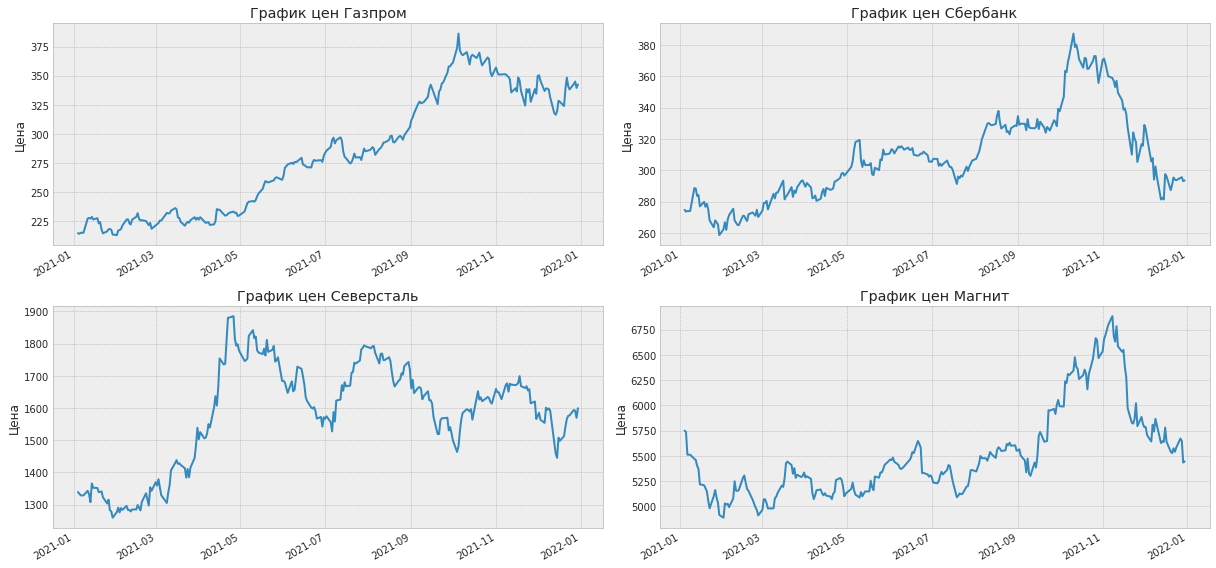

In [11]:
# Строим графики цен для каждой компании
plt.figure(figsize=(17, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['close'].plot()
    plt.ylabel('Цена')
    plt.xlabel(None)
    plt.title(f"График цен {company_name[i - 1]}")
plt.tight_layout()

Отобразим обьемы торгов из этого параметра мы видим ликвидность акций.Крупный объем торгов указывает на высокий интерес у участников рынка к данному финансовому инструменту. Чем выше оборот, тем выше ликвидность данного биржевого товара.

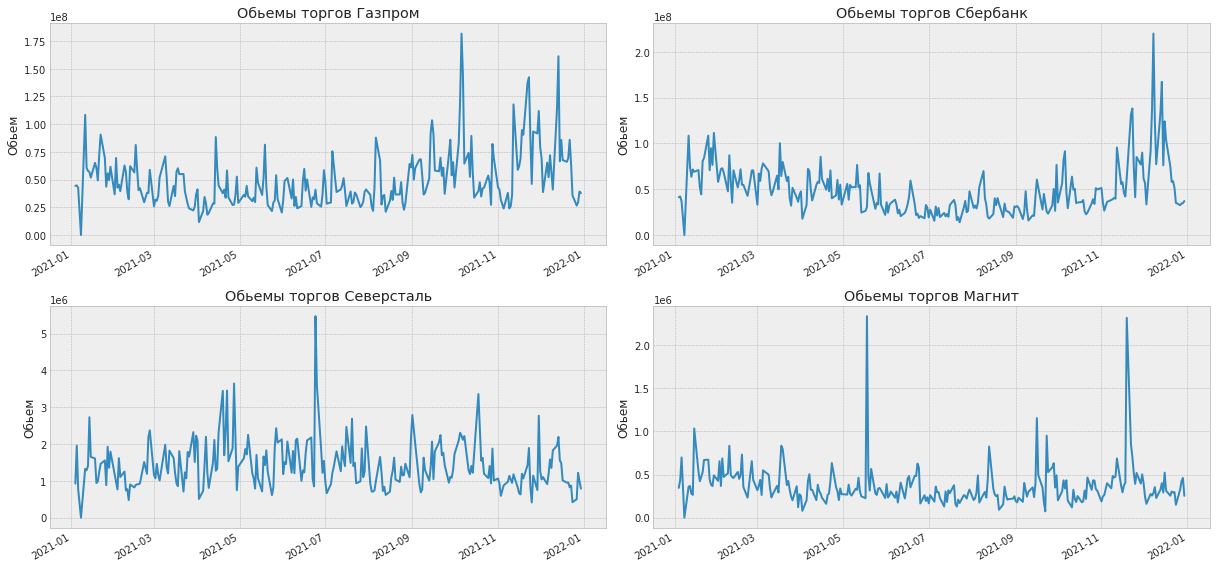

In [12]:
# Строим графики обьемов торгов для выбранных компаний.
plt.figure(figsize=(17, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['volume'].plot()
    plt.ylabel('Обьем')
    plt.xlabel(None)
    plt.title(f"Обьемы торгов {company_name[i - 1]}")
    
plt.tight_layout()

В техническом анализе есть такое понятие как Скользящие средние (Moving Averages, MA) – это яркие представители трендовых индикаторов. Они представ­ляют собой результат математических расчетов на основе ценовых по­казателей и могут использоваться для прогнозирования ценовых изменений.

In [13]:
# Выбираем интервалы скользяшщих средних.
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"Скользящая средняя {ma} дней"
        company[column_name] = company['close'].rolling(ma).mean()

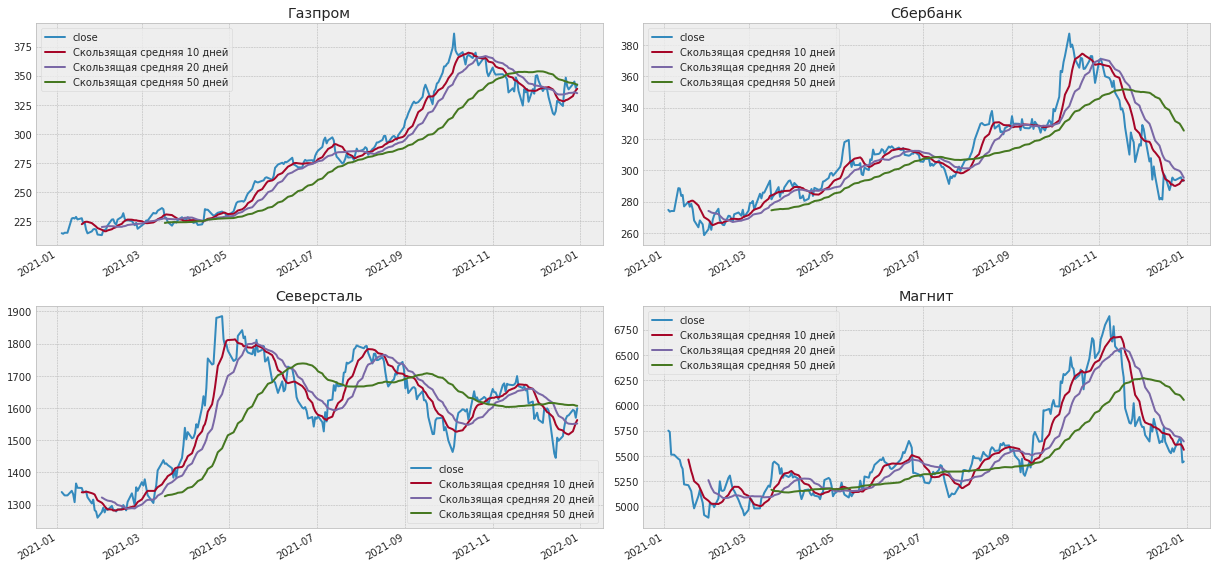

In [14]:
# Строим графики скользящих средних.
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(17)

GAZP[['close', 'Скользящая средняя 10 дней', 'Скользящая средняя 20 дней', 'Скользящая средняя 50 дней']].plot(ax=axes[0,0])
axes[0,0].set_title('Газпром')

SBER[['close', 'Скользящая средняя 10 дней', 'Скользящая средняя 20 дней', 'Скользящая средняя 50 дней']].plot(ax=axes[0,1])
axes[0,1].set_title('Сбербанк')

CHMF[['close', 'Скользящая средняя 10 дней', 'Скользящая средняя 20 дней', 'Скользящая средняя 50 дней']].plot(ax=axes[1,0])
axes[1,0].set_title('Северсталь')

MGNT[['close', 'Скользящая средняя 10 дней', 'Скользящая средняя 20 дней', 'Скользящая средняя 50 дней']].plot(ax=axes[1,1])
axes[1,1].set_title('Магнит')

fig.tight_layout()

Теперь проанализируем риск акции. Для этого нужно более внимательно изучить ежедневные изменения акций, а не только их абсолютную стоимость.

In [15]:
for company in company_list:
    company['Дневная доходность'] = company['close'].pct_change()

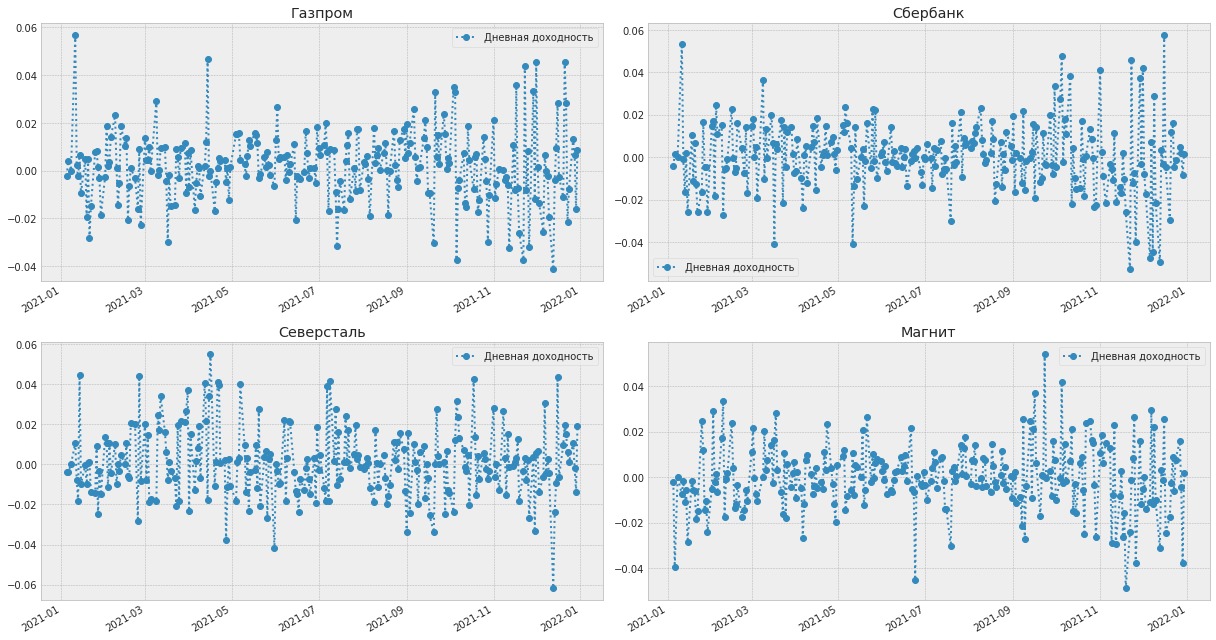

In [16]:
# Ежедневный процент изменения цены.
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(9)
fig.set_figwidth(17)

GAZP['Дневная доходность'].plot(ax=axes[0,0], legend=True, linestyle=':', marker='o')
axes[0,0].set_title('Газпром')

SBER['Дневная доходность'].plot(ax=axes[0,1], legend=True, linestyle=':', marker='o')
axes[0,1].set_title('Сбербанк')

CHMF['Дневная доходность'].plot(ax=axes[1,0], legend=True, linestyle=':', marker='o')
axes[1,0].set_title('Северсталь')

MGNT['Дневная доходность'].plot(ax=axes[1,1], legend=True, linestyle=':', marker='o')
axes[1,1].set_title('Магнит')

fig.tight_layout()

Выведем среднее изменение цены.Эти данные дают нам понимание и расчет риска при вложениях в выбраную компанию.

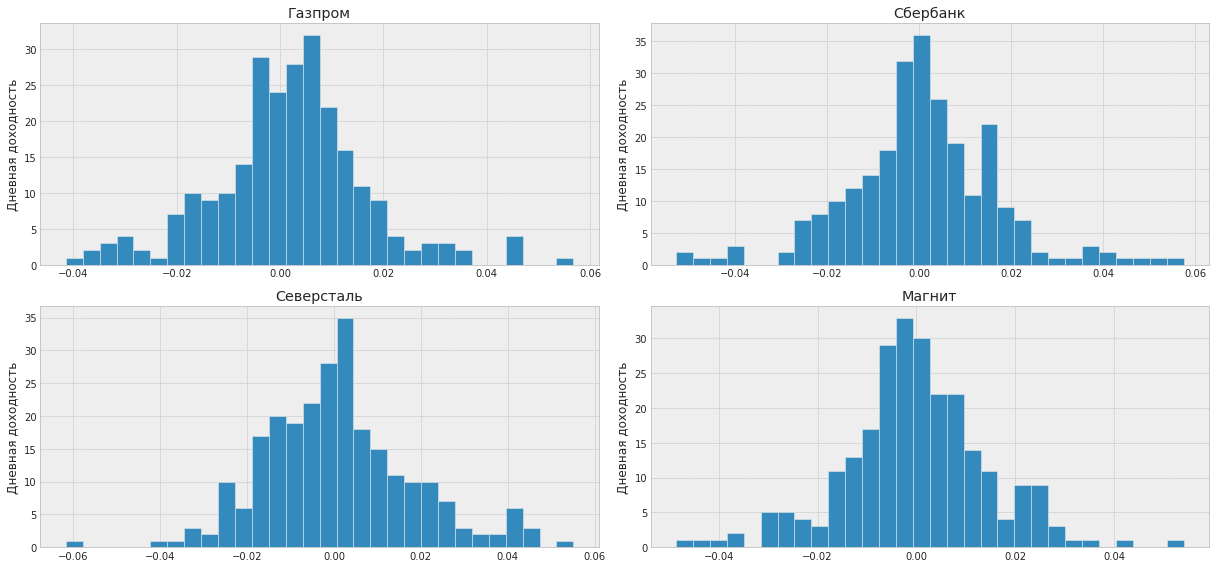

In [17]:
plt.figure(figsize=(17, 8))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Дневная доходность'].hist(bins=30)
    plt.ylabel('Дневная доходность')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

Расмотрели основные критерии вложения в акции, это направление тренда,покупать или продавать и возможная прибиль(убыток). Теперь попытаемся спрогнозировать с помощью нейросети возможнуню цену акции.

# Прогнозированние цены на акции Газпром с помощью Рекуррентной LSTM сети.

In [18]:
# Получение даных по Газпром с 2010 по 2020 год 
df_GAZP = get_data("GAZP.ME", start_date='2010-03-03', end_date='2022-01-01')
# Чтение данных в таблицы с удалением ненужных столбцов
df_GAZP = df_GAZP.drop(columns=['ticker'])

In [19]:
# Смотрим данные.
df_GAZP

,open,high,low,close,adjclose,volume
2010-03-03,168.839996,171.100006,167.119995,170.100006,85.254738,15012689
2010-03-04,169.009995,174.440002,168.369995,172.270004,86.342354,22078020
2010-03-05,174.050003,177.559998,173.759995,176.800003,88.612801,27804988
2010-03-09,176.610001,178.089996,174.339996,175.470001,87.946190,20023702
2010-03-10,174.800003,177.710007,172.649994,173.770004,87.094147,19300420
...,...,...,...,...,...,...
2021-12-24,339.200012,340.769989,334.549988,338.250000,338.250000,35784290
2021-12-27,340.179993,343.500000,340.100006,342.779999,342.779999,26628780
2021-12-28,346.299988,346.570007,344.480011,345.000000,345.000000,29673520
2021-12-29,342.200012,343.850006,337.130005,339.489990,339.489990,39270301


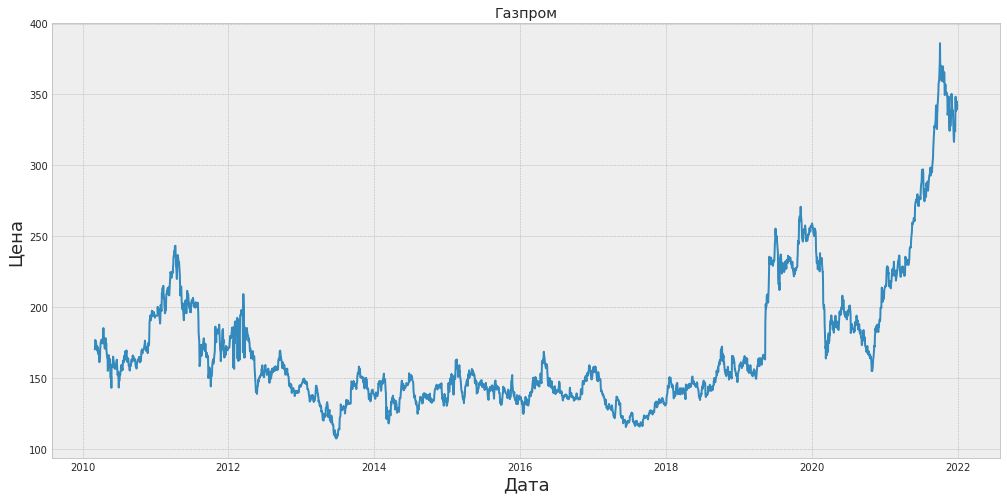

In [20]:
# Выведем график цены с 2010 по 2022 год.
plt.figure(figsize=(17,8))
plt.title('Газпром')
plt.plot(df_GAZP['close'])
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Цена', fontsize=18)
plt.show()

In [21]:
# Создаем новый дата фрейм толко с ценами закрытия.
data = df_GAZP.filter(['close'])
# Записываем в массив
dataset = data.values

# Берем количество строк для обучения модели
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2817

In [22]:
# Посмотрим размерность
dataset.shape

(2965, 1)

In [23]:
# Нормализируем данные
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.22540515],
       [0.23318515],
       [0.24942637],
       ...,
       [0.85246667],
       [0.83271187],
       [0.84339598]])

In [24]:
# Создаем набор обучающих данных
train_data = scaled_data[0:int(training_data_len), :]
# Делим данные на x_train и y_train
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Преобразовываем в массив
x_train, y_train = np.array(x_train), np.array(y_train)

# Делаем решейп
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape,y_train.shape)

[array([0.22540515, 0.23318515, 0.24942637, 0.24465797, 0.23856304,
       0.22726945, 0.23476268, 0.22242938, 0.22988672, 0.23200201,
       0.22719778, 0.21450594, 0.22250105, 0.21644201, 0.20658255,
       0.19744013, 0.19313783, 0.20550696, 0.22662413, 0.23042449,
       0.24297289, 0.24419187, 0.24612794, 0.25050195, 0.24293706,
       0.24132365, 0.24351066, 0.24440697, 0.24046322, 0.26591852,
       0.27939912, 0.26086335, 0.2412161 , 0.24351066, 0.23612504,
       0.22755627, 0.24297289, 0.25369283, 0.24512407, 0.22705434,
       0.24118026, 0.2250466 , 0.20435965, 0.2042521 , 0.20278213,
       0.17126774, 0.1874014 , 0.21095657, 0.19959125, 0.18869209,
       0.1941417 , 0.20095367, 0.18134231, 0.15710598, 0.15334145,
       0.15692671, 0.12824465, 0.18360104, 0.18367276, 0.1815933 ])]
[0.18862037417679078]

[array([0.22540515, 0.23318515, 0.24942637, 0.24465797, 0.23856304,
       0.22726945, 0.23476268, 0.22242938, 0.22988672, 0.23200201,
       0.22719778, 0.21450594, 0.22

In [25]:
# Строим LSTM модель.
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25,activation='relu'))
model.add(Dense(1,activation='linear'))

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Обучаем модель
history = model.fit(x_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
2757/2757 [==============================] - 83s 29ms/step - loss: 7.0435e-04
Epoch 2/30
2757/2757 [==============================] - 78s 28ms/step - loss: 3.2589e-04
Epoch 3/30
2757/2757 [==============================] - 78s 28ms/step - loss: 3.2473e-04
Epoch 4/30
2757/2757 [==============================] - 78s 28ms/step - loss: 2.7832e-04
Epoch 5/30
2757/2757 [==============================] - 78s 28ms/step - loss: 2.6628e-04
Epoch 6/30
2757/2757 [==============================] - 77s 28ms/step - loss: 2.6057e-04
Epoch 7/30
2757/2757 [==============================] - 79s 29ms/step - loss: 2.5733e-04
Epoch 8/30
2757/2757 [==============================] - 78s 28ms/step - loss: 2.3092e-04
Epoch 9/30
2757/2757 [==============================] - 79s 29ms/step - loss: 2.3208e-04
Epoch 10/30
2757/2757 [==============================] - 79s 29ms/step - loss: 2.2461e-04
Epoch 11/30
2757/2757 [==============================] - 79s 28ms/step - loss: 2.2016e-04
Epoch 12/30
2757/27

In [26]:
# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Обучаем модель
history = model.fit(x_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
2757/2757 [==============================] - 82s 29ms/step - loss: 1.4280e-04
Epoch 2/30
2757/2757 [==============================] - 79s 29ms/step - loss: 1.4298e-04
Epoch 3/30
2757/2757 [==============================] - 79s 29ms/step - loss: 1.4179e-04
Epoch 4/30
2757/2757 [==============================] - 78s 28ms/step - loss: 1.4132e-04
Epoch 5/30
2757/2757 [==============================] - 78s 28ms/step - loss: 1.4214e-04
Epoch 6/30
2757/2757 [==============================] - 78s 28ms/step - loss: 1.4112e-04
Epoch 7/30
2757/2757 [==============================] - 78s 28ms/step - loss: 1.4079e-04
Epoch 8/30
2757/2757 [==============================] - 79s 29ms/step - loss: 1.4074e-04
Epoch 9/30
2757/2757 [==============================] - 78s 28ms/step - loss: 1.4102e-04
Epoch 10/30
2757/2757 [==============================] - 79s 29ms/step - loss: 1.4011e-04
Epoch 11/30
2757/2757 [==============================] - 81s 29ms/step - loss: 1.3971e-04
Epoch 12/30
2757/27

In [27]:
# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

# Обучаем модель
history = model.fit(x_train, y_train, batch_size=1, epochs=15)

Epoch 1/15
2757/2757 [==============================] - 82s 29ms/step - loss: 1.3228e-04
Epoch 2/15
2757/2757 [==============================] - 81s 29ms/step - loss: 1.3193e-04
Epoch 3/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3193e-04
Epoch 4/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3166e-04
Epoch 5/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3190e-04
Epoch 6/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3176e-04
Epoch 7/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3197e-04
Epoch 8/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3179e-04
Epoch 9/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3191e-04
Epoch 10/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3137e-04
Epoch 11/15
2757/2757 [==============================] - 80s 29ms/step - loss: 1.3179e-04
Epoch 12/15
2757/27

In [28]:
# Пересохранение обученной модели полностью (веса и архитектура) после всех эпох
model.save('model_diplom_all.h5')

In [29]:
from tensorflow.keras.models import load_model
model = load_model('model_diplom_all.h5')

In [30]:
# Создаем набор тестовых данных
test_data = scaled_data[training_data_len - 60: , :]
# Тестовые данные создаем из данных которые не брались в тренировочные
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Преобразуем в массив
x_test = np.array(x_test)

# делаем решейп
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Получаем предсказанные значения цен 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Получить среднеквадратичную ошибку (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("Среднеквадратичная ошибка с тестовыми данными ",rmse)

Среднеквадратичная ошибка с тестовыми данными  8.5512054283275


In [31]:
# Визуализируем полученный результат 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


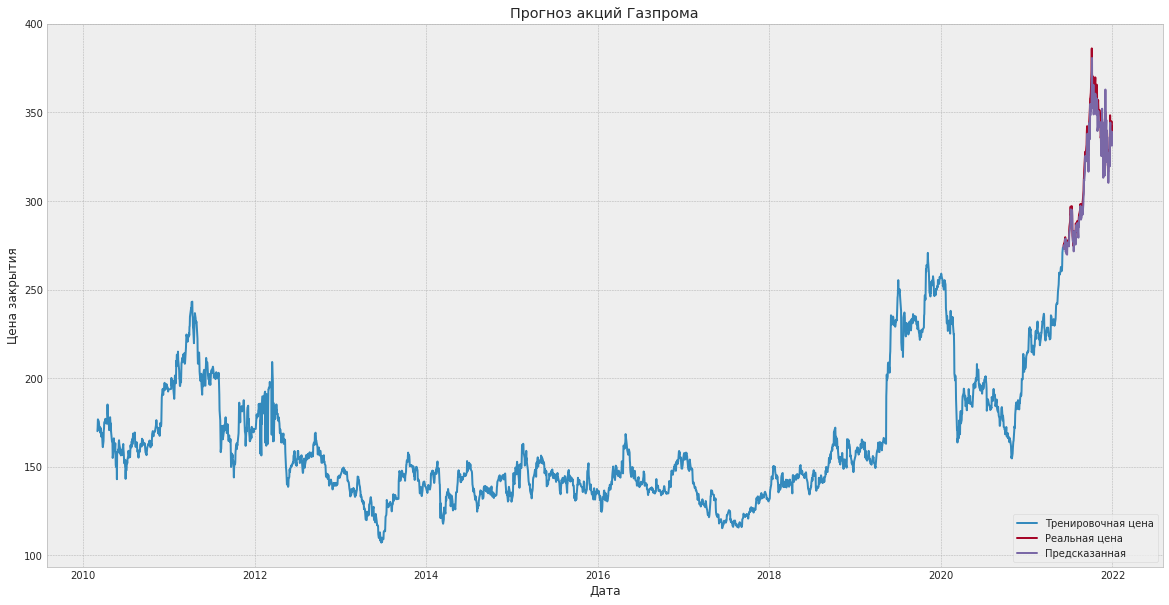

In [32]:
# График целиком
plt.figure(figsize=(20,10))
plt.title('Прогноз акций Газпрома')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Тренировочная цена', 'Реальная цена', 'Предсказанная'], loc='lower right')
plt.show()

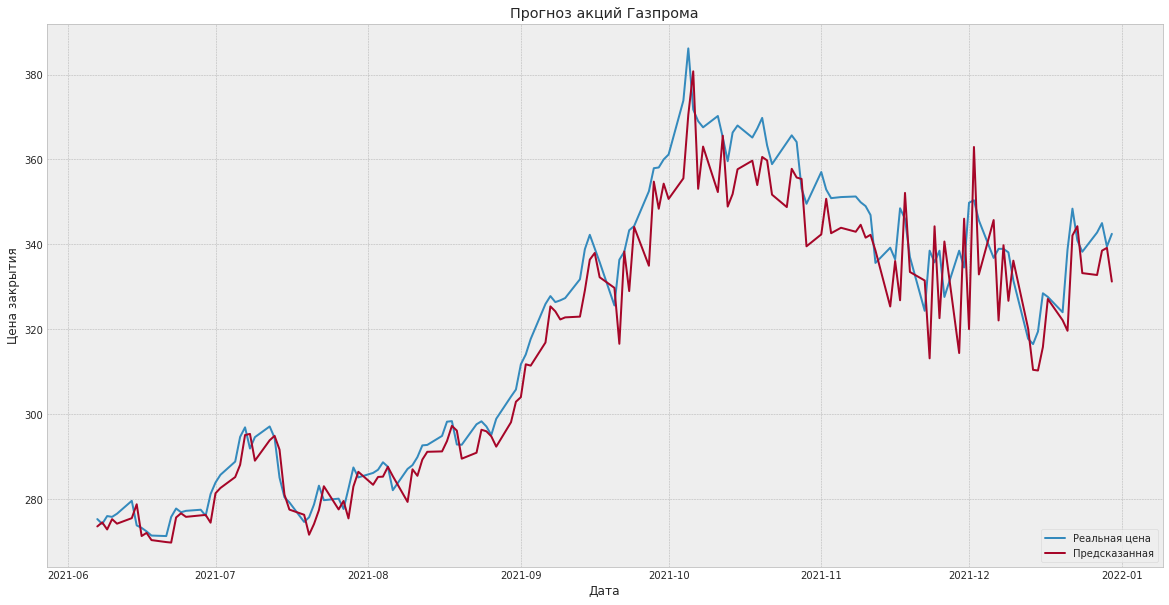

In [33]:
# Разница цены реальной и предсказаной
plt.figure(figsize=(20,10))
plt.title('Прогноз акций Газпрома')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Реальная цена', 'Предсказанная'], loc='lower right')
plt.show()

In [34]:
# Посмотрим на реальные и предсказанные цены
valid

,close,Predictions
2021-06-07,275.279999,273.549316
2021-06-08,274.149994,274.500916
2021-06-09,275.989990,272.835022
2021-06-10,275.799988,275.270172
2021-06-11,276.540009,274.199219
...,...,...
2021-12-24,338.250000,333.218079
2021-12-27,342.779999,332.776794
2021-12-28,345.000000,338.515747
2021-12-29,339.489990,339.165527


Подведем итог: В данной дипломной работе мы расмотрели небольшой технический анализ, расчет рисков и неплохое предсказание цены данную работу можно интегрировать в какой-нибудь финансовый сайт или приложение для инвестиций. Так же ее можно доработать более расширенным техническим анализом и предсказание цены сделать на разных тайм фреймах .